# Cluster LVs
This notebook will analyze the latent variables learned by MousiPLIER to see if any studies in the training data have strong clusters in LV space 

In [1]:
import math

import pandas as pd
import pyreadr
from sklearn import cluster, metrics
from tqdm import tqdm
from plotnine import *


from src.transform import PlierTransform

In [2]:
# Load LVs
transformer = PlierTransform('output/filtered_Z.tsv', 'output/filtered_lambda.txt')

In [3]:
# Load metadata
metadata_df = pyreadr.read_r('data/metadata_df.rda')['metadata_df']
metadata_df

,rail_id,external_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
0,12124608,SRR8249203,SRP170963,SRS4082403,SRX5067019,SRA815346,GEO,NaN,Deep single-cell RNAseq of postnatal day 7 mic...,We generated single-cell RNAseq profiles of 36...,...,0.0,34.5,27.2,SRS4082403,NaN,NaN,scrna-seq,scrna-seq,NaN,NaN
1,12124736,SRR8249204,SRP170963,SRS4082404,SRX5067020,SRA815346,GEO,NaN,Deep single-cell RNAseq of postnatal day 7 mic...,We generated single-cell RNAseq profiles of 36...,...,0.0,34.5,27.2,SRS4082404,NaN,NaN,scrna-seq,scrna-seq,NaN,NaN
2,12124992,SRR8249206,SRP170963,SRS4082407,SRX5067022,SRA815346,GEO,NaN,Deep single-cell RNAseq of postnatal day 7 mic...,We generated single-cell RNAseq profiles of 36...,...,0.0,34.5,27.2,SRS4082407,NaN,NaN,scrna-seq,scrna-seq,NaN,NaN
3,12126273,SRR8249210,SRP170963,SRS4082410,SRX5067026,SRA815346,GEO,NaN,Deep single-cell RNAseq of postnatal day 7 mic...,We generated single-cell RNAseq profiles of 36...,...,0.0,34.5,27.3,SRS4082410,NaN,NaN,scrna-seq,scrna-seq,NaN,NaN
4,12126401,SRR8249211,SRP170963,SRS4082411,SRX5067027,SRA815346,GEO,NaN,Deep single-cell RNAseq of postnatal day 7 mic...,We generated single-cell RNAseq profiles of 36...,...,0.0,34.4,27.1,SRS4082411,NaN,NaN,scrna-seq,scrna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416837,3842673,SRR5445513,SRP103859,SRS2122385,SRX2734511,SRA554033,GEO,NaN,Next Generation Sequencing of p53 KO and Utx/p...,Hematopoitic stem cells from Utx/p53 DKO mice ...,...,0.0,36.8,24.4,SRS2122385,NaN,NaN,rna-seq,rna-seq,NaN,NaN
416838,3842705,SRR5445514,SRP103859,SRS2122385,SRX2734511,SRA554033,GEO,NaN,Next Generation Sequencing of p53 KO and Utx/p...,Hematopoitic stem cells from Utx/p53 DKO mice ...,...,0.0,34.9,23.1,SRS2122385,NaN,NaN,rna-seq,rna-seq,NaN,NaN
416839,3842736,SRR5445515,SRP103859,SRS2122377,SRX2734512,SRA554033,GEO,NaN,Next Generation Sequencing of p53 KO and Utx/p...,Hematopoitic stem cells from Utx/p53 DKO mice ...,...,0.0,36.5,23.2,SRS2122377,NaN,NaN,rna-seq,rna-seq,NaN,NaN
416840,3842768,SRR5445516,SRP103859,SRS2122377,SRX2734512,SRA554033,GEO,NaN,Next Generation Sequencing of p53 KO and Utx/p...,Hematopoitic stem cells from Utx/p53 DKO mice ...,...,0.0,36.6,24.3,SRS2122377,NaN,NaN,rna-seq,rna-seq,NaN,NaN


In [4]:
tmp_df = metadata_df.loc[:, ['study', 'sra.study_title']]
tmp_df = tmp_df.drop_duplicates()
study_to_title = dict(zip(tmp_df['study'],tmp_df['sra.study_title']))
tmp_df

,study,sra.study_title
0,SRP170963,Deep single-cell RNAseq of postnatal day 7 mic...
369,SRP045763,Dynamics of gene silencing during X inactivati...
391,DRP005463,Transcriptome of Mpst KO mouse
403,SRP172863,Bach2 is a critical negative regulator of Tfh ...
411,SRP186363,Trained immunity-promoting nanobiologics suppr...
...,...,...
416762,SRP194159,Effector TH17 cells give rise to long-lived TR...
416772,SRP083959,RNA profiling to describe the transcriptional ...
416788,SRP098559,ATR Mutations Promote the Growth of Melenama T...
416812,ERP010759,Transcriptome_of_the_vomeronasal_organ_in_Vmn2...


In [5]:
metadata_df['study'].value_counts()

SRP150473    28650
SRP187821    12284
SRP144582     8124
ERP112843     6614
SRP139086     4776
             ...  
SRP035427        1
SRP121168        1
SRP220664        1
SRP121135        1
SRP121127        1
Name: study, Length: 10088, dtype: int64

In [6]:
expression_file = 'data/no_scrna_rpkm.tsv'
line_count = 0
with open(expression_file, 'r') as in_file:
    for line in in_file:
        line_count += 1
print(line_count)

190112


In [7]:
# Input data is too large to store in memory in expression space, but it will fit in LV space
lv_dfs = []

NUM_SLICES = 10

for i in tqdm(range(NUM_SLICES)):
    nrows = math.ceil(line_count / NUM_SLICES)
    # Always read the header row by starting skip at row 1
    skiprows = range(1, i * nrows)
    data_df = pd.read_csv('data/no_scrna_rpkm.tsv', sep='\t', header=0, skiprows=skiprows, nrows=nrows)
    sample_ids = data_df['sample']
    transformed_df = transformer.transform(data_df)
    transformed_df['sample'] = sample_ids
    lv_dfs.append(transformed_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [14:32<00:00, 87.22s/it]


In [8]:
lv_df = pd.concat(lv_dfs)
print(lv_df.shape)
lv_df

(190112, 197)


,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV188,LV189,LV190,LV191,LV192,LV193,LV194,LV195,LV196,sample
0,-0.016630,-0.026942,-0.015635,0.033415,0.007214,-0.002052,-0.008481,-0.013915,-0.098229,-0.013462,...,-0.010631,0.010824,-0.018213,0.009058,-0.011831,0.050830,0.002404,-0.037124,0.021725,SRR1557112
1,-0.019498,-0.016332,-0.024485,0.006340,-0.006971,-0.011673,-0.010778,-0.023543,-0.105526,-0.017519,...,-0.005466,-0.003106,-0.015373,0.001975,-0.018783,0.083679,-0.003550,0.091549,-0.005003,SRR1557113
2,-0.007805,-0.015924,-0.017381,0.013943,-0.007270,0.000067,0.015086,-0.023686,-0.108203,-0.023622,...,0.000755,0.017406,-0.018852,-0.008103,-0.032033,-0.013693,-0.009100,0.105960,-0.025597,SRR1557114
3,-0.012973,-0.019249,-0.020952,-0.011626,-0.008815,0.002477,-0.024644,-0.016858,-0.105234,-0.016088,...,-0.006642,-0.006226,-0.006120,-0.013609,-0.021917,0.058357,-0.008944,0.097394,-0.006806,SRR1557115
4,-0.008012,-0.018679,-0.019879,-0.016724,-0.014097,-0.004841,-0.024782,-0.005431,-0.102108,-0.010897,...,-0.011763,-0.003315,-0.009140,-0.015164,-0.001997,0.095090,-0.013426,0.065233,0.008561,SRR1557116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18999,-0.020930,-0.033730,-0.009624,-0.005603,-0.023101,-0.009814,-0.062296,-0.014324,-0.089560,-0.005474,...,-0.003477,-0.014207,-0.006050,-0.018633,-0.004109,0.054167,-0.003924,-0.070536,0.001066,SRR5445513
19000,-0.020529,-0.032853,-0.010576,-0.006039,-0.024286,-0.009745,-0.066634,-0.014007,-0.098707,-0.006140,...,-0.002646,-0.015283,-0.004999,-0.019502,-0.007459,0.062781,-0.004135,-0.073554,0.001312,SRR5445514
19001,-0.021876,-0.036690,-0.016568,-0.001905,-0.016355,-0.005478,-0.023354,-0.013587,-0.103818,-0.005980,...,-0.001611,-0.009249,0.000321,-0.012844,-0.016115,-0.026269,-0.003601,-0.044239,-0.005004,SRR5445515
19002,-0.020415,-0.036915,-0.015352,-0.001895,-0.016718,-0.005868,-0.022357,-0.014159,-0.104752,-0.005584,...,-0.001305,-0.009889,-0.000467,-0.012161,-0.016724,-0.027038,-0.004082,-0.044152,-0.005243,SRR5445516


In [9]:
lv_df_with_metadata = lv_df.merge(metadata_df, left_on='sample', right_on='external_id')

In [10]:
lv_df_with_metadata

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
0,-0.016630,-0.026942,-0.015635,0.033415,0.007214,-0.002052,-0.008481,-0.013915,-0.098229,-0.013462,...,2.6,25.1,8.9,SRS688769,NaN,NaN,rna-seq,rna-seq,NaN,NaN
1,-0.019498,-0.016332,-0.024485,0.006340,-0.006971,-0.011673,-0.010778,-0.023543,-0.105526,-0.017519,...,2.8,24.9,8.9,SRS688770,NaN,NaN,rna-seq,rna-seq,NaN,NaN
2,-0.007805,-0.015924,-0.017381,0.013943,-0.007270,0.000067,0.015086,-0.023686,-0.108203,-0.023622,...,2.7,24.3,8.7,SRS688771,NaN,NaN,rna-seq,rna-seq,NaN,NaN
3,-0.012973,-0.019249,-0.020952,-0.011626,-0.008815,0.002477,-0.024644,-0.016858,-0.105234,-0.016088,...,2.5,24.9,8.9,SRS688772,NaN,NaN,rna-seq,rna-seq,NaN,NaN
4,-0.008012,-0.018679,-0.019879,-0.016724,-0.014097,-0.004841,-0.024782,-0.005431,-0.102108,-0.010897,...,2.5,25.4,9.1,SRS688773,NaN,NaN,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190107,-0.020930,-0.033730,-0.009624,-0.005603,-0.023101,-0.009814,-0.062296,-0.014324,-0.089560,-0.005474,...,0.0,36.8,24.4,SRS2122385,NaN,NaN,rna-seq,rna-seq,NaN,NaN
190108,-0.020529,-0.032853,-0.010576,-0.006039,-0.024286,-0.009745,-0.066634,-0.014007,-0.098707,-0.006140,...,0.0,34.9,23.1,SRS2122385,NaN,NaN,rna-seq,rna-seq,NaN,NaN
190109,-0.021876,-0.036690,-0.016568,-0.001905,-0.016355,-0.005478,-0.023354,-0.013587,-0.103818,-0.005980,...,0.0,36.5,23.2,SRS2122377,NaN,NaN,rna-seq,rna-seq,NaN,NaN
190110,-0.020415,-0.036915,-0.015352,-0.001895,-0.016718,-0.005868,-0.022357,-0.014159,-0.104752,-0.005584,...,0.0,36.6,24.3,SRS2122377,NaN,NaN,rna-seq,rna-seq,NaN,NaN


In [11]:
lv_df_with_metadata['study'].value_counts() > 10

ERP008773     True
ERP110541     True
SRP132477     True
SRP092108     True
ERP004375     True
             ...  
SRP121143    False
SRP095667    False
SRP167843    False
SRP121167    False
SRP068858    False
Name: study, Length: 9270, dtype: bool

In [12]:
frequent_studies = set(lv_df_with_metadata['study'].value_counts()[(lv_df_with_metadata['study'].value_counts() > 30)].index)
filtered_study_df = lv_df_with_metadata[lv_df_with_metadata['study'].isin(frequent_studies)]
filtered_study_df['study'].value_counts()

ERP008773    2861
ERP110541    2112
SRP132477    1767
SRP092108    1419
ERP004375    1271
             ... 
SRP111723      31
SRP045805      31
SRP123623      31
SRP066809      31
SRP045874      31
Name: study, Length: 1205, dtype: int64

## Plot all Microglia LVs

In [13]:
studies = set(filtered_study_df['study'])

# Overlaps: LV46 (wt_astrocytes), LV99 (AD_astrocytes)
microglia_lvs = ['LV3', 'LV46', 'LV48', 'LV51', 'LV86', 'LV99', 'LV115', 'LV159']
# Append striatal-associated LV
microglia_lvs.append('LV41')

results = {'scores': [], 'studies': [], 'lv': []}
for lv in microglia_lvs:
    for study in studies:
        kmeans = cluster.KMeans(n_clusters=2, random_state=42)
        study_df = lv_df_with_metadata[lv_df_with_metadata['study'] == study]

        lv_data = study_df[lv].values.reshape(-1, 1)
        clusters = kmeans.fit_predict(lv_data)

        score = metrics.silhouette_score(lv_data, clusters, random_state=42)
        results['scores'].append(score)
        results['studies'].append(study)
        results['lv'].append(lv)
    

In [14]:
result_df = pd.DataFrame(results)
result_df = result_df.sort_values(by='scores', ascending=False)
top_ten_studies = result_df.groupby('lv').head(10)
top_ten_studies

,scores,studies,lv
6082,0.999155,SRP194587,LV99
31,0.986903,SRP163086,LV3
5411,0.983073,SRP119935,LV86
5466,0.981128,SRP185583,LV86
5727,0.978730,DRP003810,LV86
...,...,...,...
2755,0.913307,SRP026048,LV48
2184,0.912024,SRP125890,LV46
1764,0.911851,SRP070948,LV46
2099,0.905495,SRP035667,LV46


In [15]:
for lv in microglia_lvs:
    score_df = top_ten_studies[top_ten_studies['lv'] == lv]
    top_studies = set(score_df['studies'])
        
    study_lvs = lv_df_with_metadata[lv_df_with_metadata['study'].isin(top_studies)]
    study_values = study_lvs.loc[:, ['study', lv]]
    
    plot = ggplot(study_values, aes(x=lv, y='study'))
    plot += geom_jitter(random_state=42)
    plot.save(f'output/{lv}-clusters.svg')
    
    plot = ggplot(study_values, aes(x=lv, y=1))
    plot += geom_jitter(random_state=42)
    plot += facet_wrap('~ study', scales='free_x')
    plot.save(f'output/{lv}-facets.svg')

/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/LV3-clusters.svg
/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/LV3-facets.svg
/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotnine/facets/facet.py:399: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/plotni

In [16]:
pd.options.display.max_colwidth = 120
pd.options.display.max_rows = 80
df_list = []
for lv in microglia_lvs:
    study_df = top_ten_studies[top_ten_studies['lv'] == lv]
    study_df['title'] = study_df['studies'].map(study_to_title)
    df_list.append(study_df)
pd.concat(df_list)

/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,scores,studies,lv,title
31,0.986903,SRP163086,LV3,TL1A is a central regulator of group 3 innate lymphoid cell function in colitis
902,0.974264,SRP126738,LV3,Replacing reprogramming factors with antibodies selected from autocrine antibody libraries
552,0.973812,ERP023143,LV3,Temporal epigenomic and transcriptomic profiling of mesenchymal differentiation
724,0.966372,ERP021517,LV3,"Apoptotic cell induced, TLR9-dependent AhR activity is required for immunologic tolerance and suppression of lupus"
1012,0.961319,SRP131971,LV3,LXR Suppresses Inflammatory Gene Expression and Neutrophil Migration through cis-Repression and Cholesterol Efflux [...
...,...,...,...,...
10691,0.957509,SRP020526,LV41,Mus musculus strain:black6 x castaneus Transcriptome or Gene expression
10148,0.956833,SRP069879,LV41,Transcriptome sequencing of mouse F1 hybrids
10344,0.955790,SRP047452,LV41,Transcriptional perturbations by long noncoding RNAs with distinct spatio-temporal expression in the mammalian brain
10275,0.953265,SRP155020,LV41,Transcriptional changes in mouse models in SCA3


In [17]:
for row in pd.concat(df_list).iterrows():
    print(row[1]['studies'], row[1]['lv'], row[1]['title'])

SRP163086 LV3 TL1A is a central regulator of group 3 innate lymphoid cell function in colitis
SRP126738 LV3 Replacing reprogramming factors with antibodies selected from autocrine antibody libraries
ERP023143 LV3 Temporal epigenomic and transcriptomic profiling of mesenchymal differentiation
ERP021517 LV3 Apoptotic cell induced, TLR9-dependent AhR activity is required for immunologic tolerance and suppression of lupus
SRP131971 LV3 LXR Suppresses Inflammatory Gene Expression and Neutrophil Migration through cis-Repression and Cholesterol Efflux [RNA-Seq]
ERP113014 LV3 RNASeq: Aryl hydrocarbon receptor governs a transcriptional programme that determines regulatory B cell differentiation and function
SRP013003 LV3 GSE36026: RNA-seq from ENCODE/LICR
SRP039402 LV3 High-resolution mapping reveals a conserved, widespread, dynamic meiotically regulated mRNA methylation program [Mm]
SRP130963 LV3 Males undergo a transient X-chromosome inactivation-like state at the onset of naïve cell differen

## Cluster Striatum LV

In [18]:
studies = set(filtered_study_df['study'])
lv = 'LV41'

results = {'scores': [], 'studies': []}

for study in studies:
    kmeans = cluster.KMeans(n_clusters=2, random_state=42)
    study_df = lv_df_with_metadata[lv_df_with_metadata['study'] == study]
    
    lv_data = study_df[lv].values.reshape(-1, 1)
    clusters = kmeans.fit_predict(lv_data)
    
    score = metrics.silhouette_score(lv_data, clusters, random_state=42)
    results['scores'].append(score)
    results['studies'].append(study)
    

<AxesSubplot:>

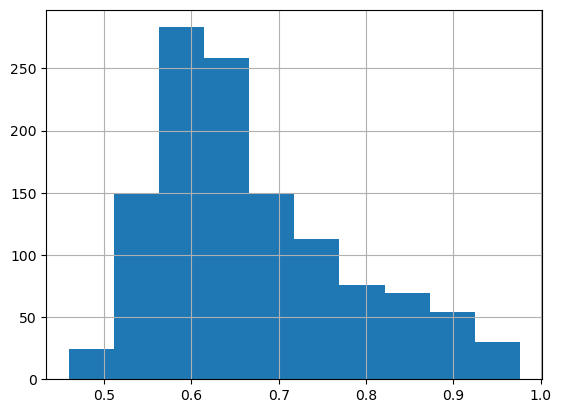

In [19]:
result_df = pd.DataFrame(results)
result_df['scores'].hist()

In [20]:
result_df.sort_values(by='scores', ascending=False)

,scores,studies
1127,0.976004,ERP005641
526,0.969815,SRP058503
164,0.967012,SRP078594
427,0.960723,SRP136494
645,0.959139,SRP070440
...,...,...
910,0.484988,SRP115903
643,0.484587,SRP198592
1142,0.478210,SRP132195
1101,0.473717,SRP151034


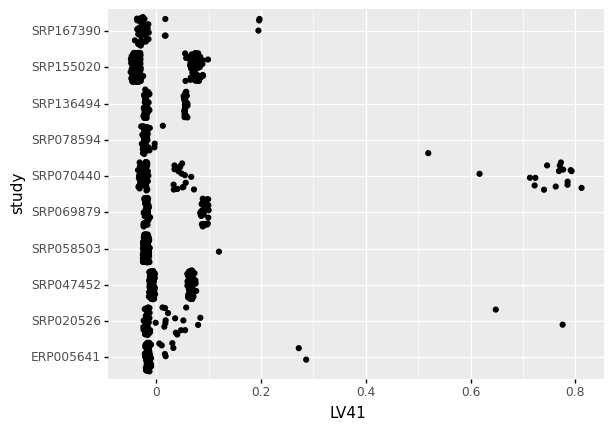

<ggplot: (8731529390721)>

In [21]:
top_studies = result_df.sort_values(by='scores', ascending=False)['studies'][:10]

plot_df = lv_df_with_metadata[lv_df_with_metadata['study'].isin(top_studies)]
plot = ggplot(plot_df, aes(x='LV41', y='study'))
plot += geom_jitter(random_state=42)
plot

In [22]:
top_study_values = lv_df_with_metadata[lv_df_with_metadata['study'].isin(top_studies)]
cols_to_keep = ['LV41', 'study', 'external_id',]
top_study_values = top_study_values.loc[:, cols_to_keep]
top_study_values

,LV41,study,external_id
8448,0.775650,SRP020526,SRR823500
8449,-0.012969,SRP020526,SRR823501
8450,-0.016334,SRP020526,SRR823502
8451,-0.016996,SRP020526,SRR823503
8452,-0.015259,SRP020526,SRR823504
...,...,...,...
179005,0.811791,SRP070440,SRR3175395
179006,0.792791,SRP070440,SRR3175396
179007,0.713340,SRP070440,SRR3175397
179008,0.746006,SRP070440,SRR3175398


### Potentially helpful code:

In [23]:
# Get all the samples for one study
study = 'SRP167390'
one_study_df = top_study_values[top_study_values['study'] == study]
one_study_df.head()

,LV41,study,external_id
86042,-0.040767,SRP167390,SRR8142802
86043,-0.031029,SRP167390,SRR8142803
86044,-0.016423,SRP167390,SRR8142804
86045,-0.030526,SRP167390,SRR8142806
86046,-0.026561,SRP167390,SRR8142807


In [24]:
# Split study samples based on a threshold to differentiate clusters
left_cluster = one_study_df[one_study_df['LV41'] < .1]
right_cluster = one_study_df[one_study_df['LV41'] > .1]